In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import *
import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle'
# In this code, the `os.environ` dictionary contains all the environment variables of the system. By assigning a value to the key
# `'KAGGLE_CONFIG_DIR'`, the code is specifying the directory path where the Kaggle configuration files are stored.

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

/content/drive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d kshitij192/cars-image-dataset

cars-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Setup data directories
train_dir = "/content/drive/MyDrive/Kaggle/Cars Dataset/train"
test_dir = "/content/drive/MyDrive/Kaggle/Cars Dataset/test"

In [ ]:
walk_through_dir("/content/drive/MyDrive/Kaggle/Cars Dataset")

There are 2 directories and 0 images in '/content/drive/MyDrive/Kaggle/Cars Dataset'.
There are 7 directories and 0 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test'.
There are 0 directories and 199 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Audi'.
There are 0 directories and 67 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Hyundai Creta'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Mahindra Scorpio'.
There are 0 directories and 74 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Rolls Royce'.
There are 0 directories and 102 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Swift'.
There are 0 directories and 106 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Tata Safari'.
There are 0 directories and 190 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/test/Toyota Innova'.
There are 7 directories and 0 images in '/content/drive/MyDrive/Kaggle/Cars Dataset/train'.
The

In [ ]:
input_path = []
label = []
 #              0        1                2                   3              4        5              6
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

for class_name in os.listdir("Cars Dataset/test"):
    for path in os.listdir("Cars Dataset/test/"+class_name):
        for i, name in enumerate(class_names):
            if class_name == name:
                label.append(i)
        input_path.append(os.path.join("Cars Dataset/test", class_name, path))

print(input_path[0], label[0])

Cars Dataset/test/Audi/1000.jpg 0


#Create dataframe

In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
#Shuffle the rows of the DataFrame using the df.sample() method with the parameter frac as 1,
#it determines what fraction of total instances need to be returned.
df.head(10)

,images,label
0,Cars Dataset/test/Hyundai Creta/99.jpg,1
1,Cars Dataset/test/Audi/863.jpg,0
2,Cars Dataset/test/Tata Safari/614.jpg,5
3,Cars Dataset/test/Toyota Innova/157.jpg,6
4,Cars Dataset/test/Audi/987.jpg,0
5,Cars Dataset/test/Swift/594.jpg,4
6,Cars Dataset/test/Mahindra Scorpio/425.jpg,2
7,Cars Dataset/test/Rolls Royce/133.jpg,3
8,Cars Dataset/test/Audi/141.jpg,0
9,Cars Dataset/test/Tata Safari/196.jpg,5


In [ ]:
df['label'].value_counts()

0    199
6    190
5    106
4    102
2     75
3     74
1     67
Name: label, dtype: int64

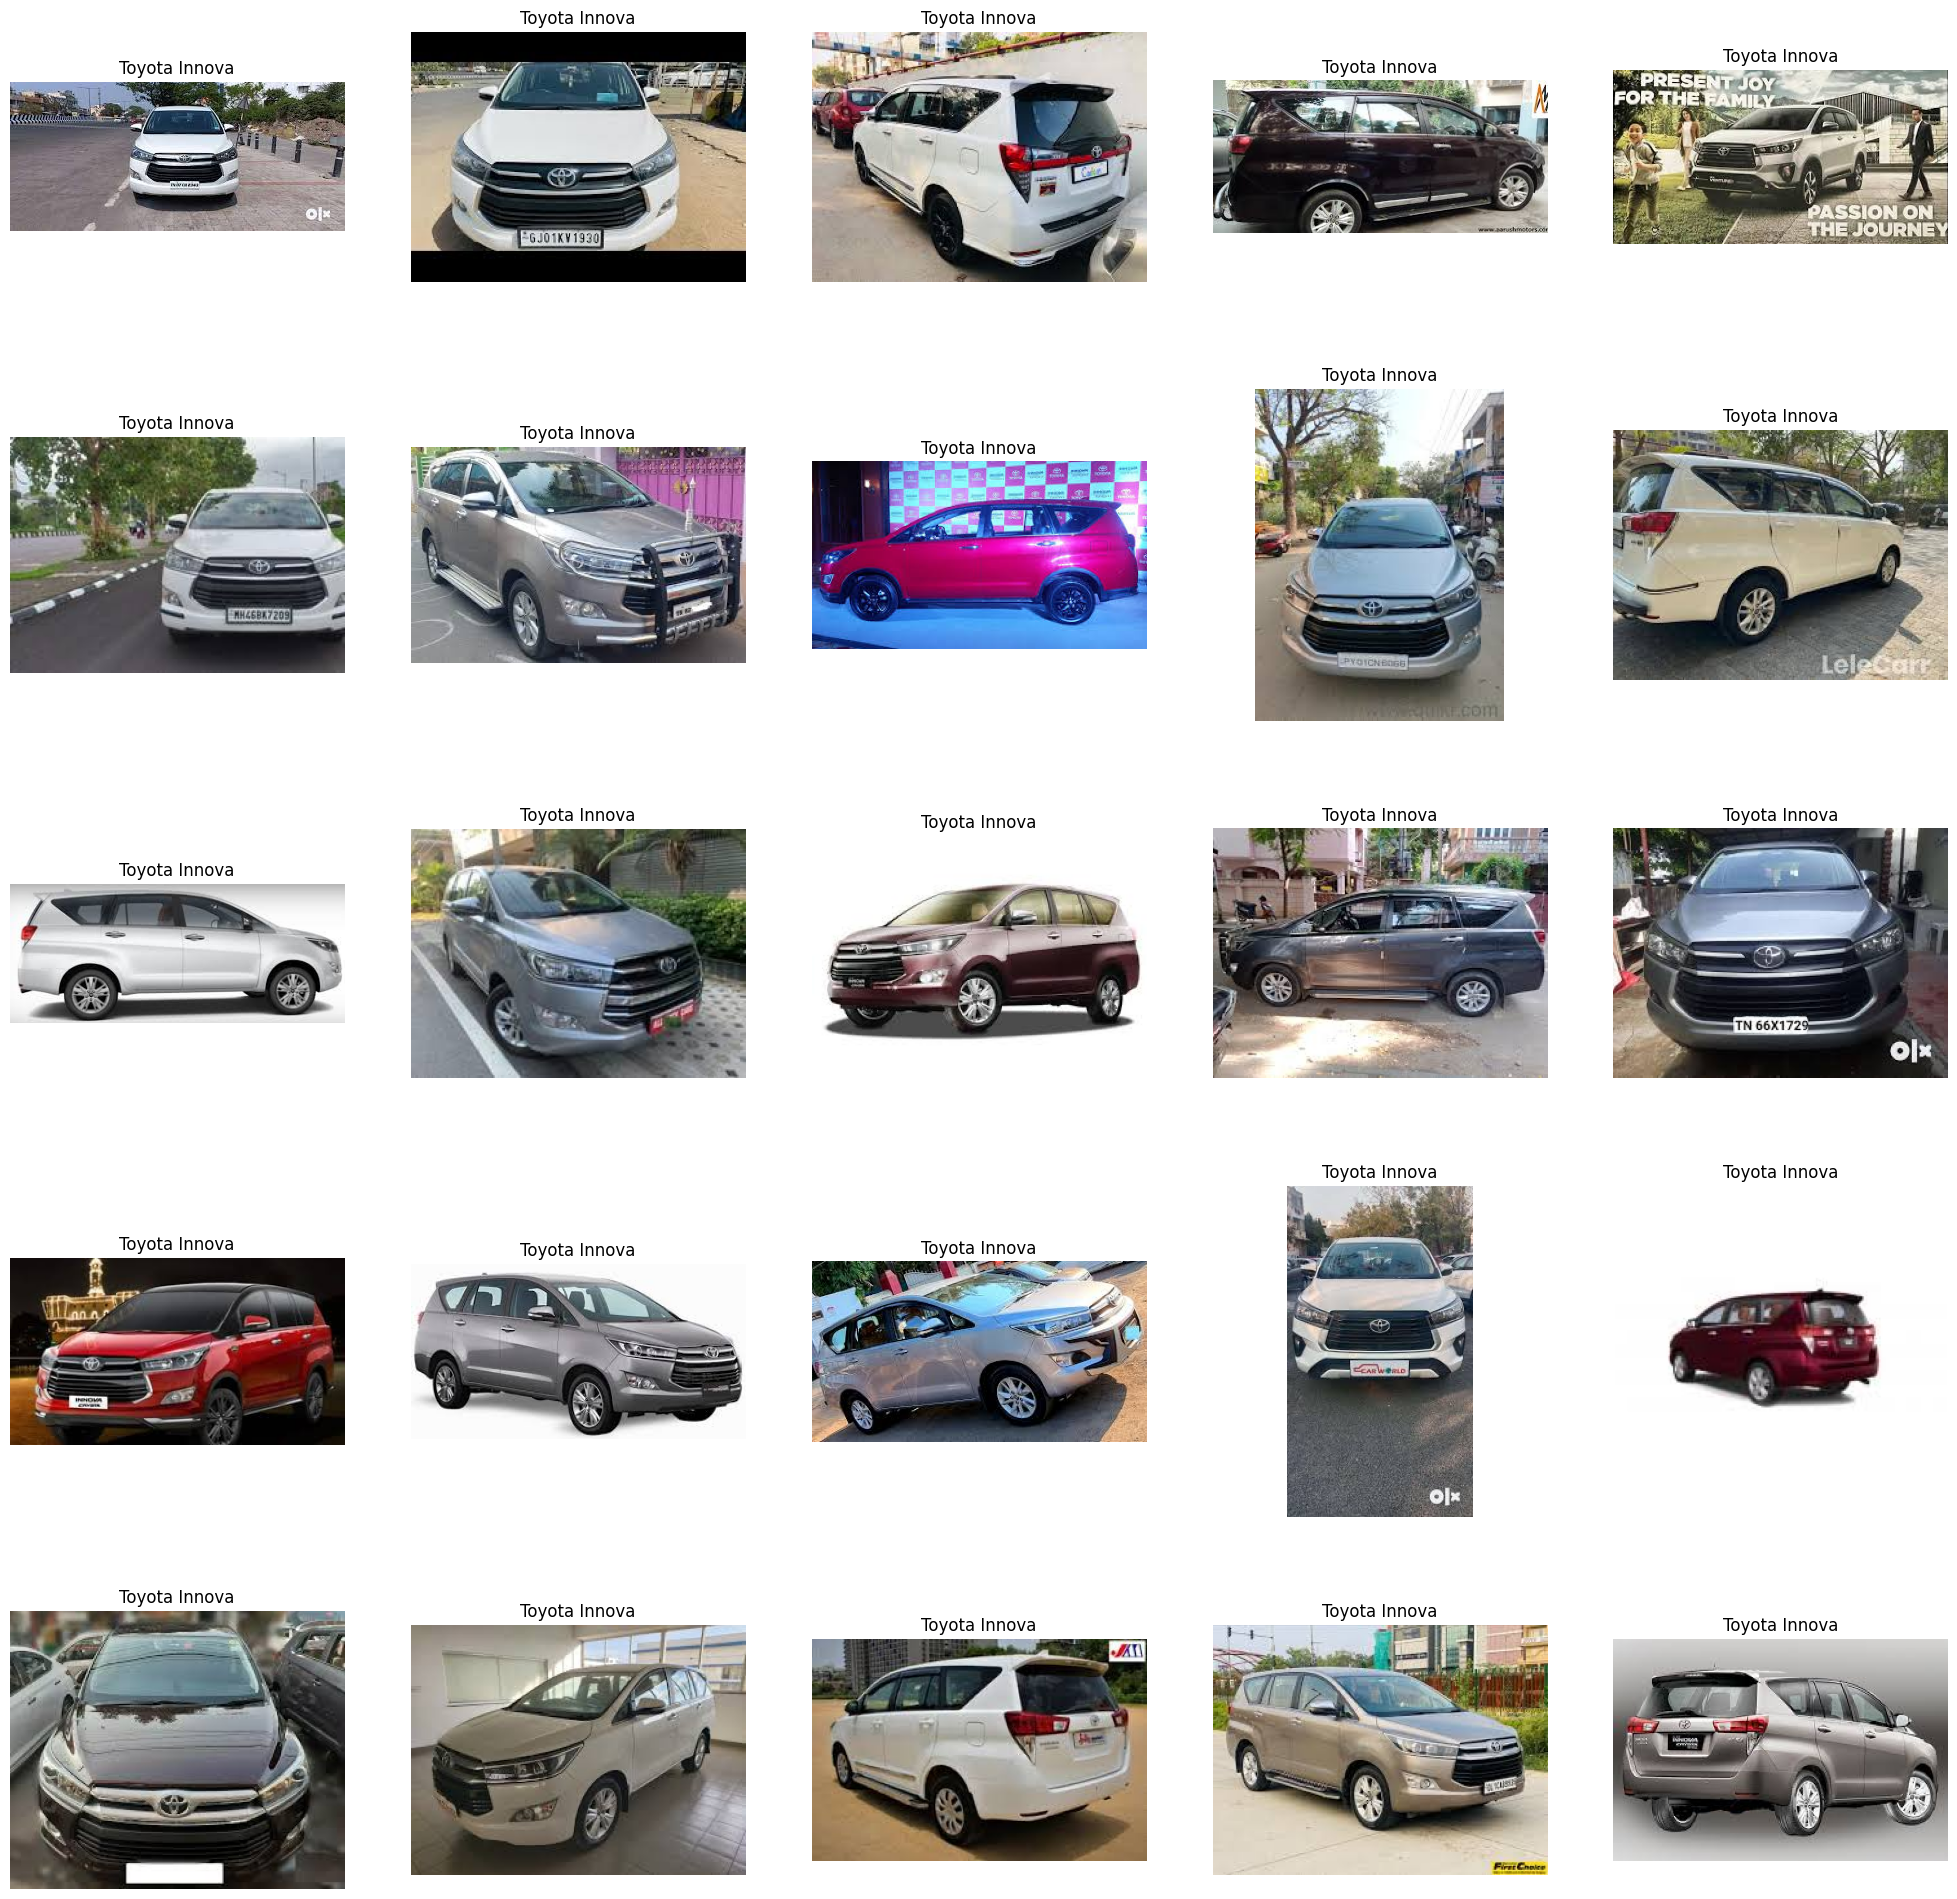

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==6]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Toyota Innova')
    plt.axis('off')

#Preprocess data

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_7_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

#Create model without using fine tuning

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(7, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_1.fit(train_data_7_classes_full,
                    epochs=5,
                    steps_per_epoch=len(train_data_7_classes_full),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231022-152826
Epoch 1/5
105/105 [==============================] - 647s 6s/step - loss: 1.4819 - accuracy: 0.4690 - val_loss: 0.9387 - val_accuracy: 0.7083
Epoch 2/5
105/105 [==============================] - 44s 411ms/step - loss: 1.0828 - accuracy: 0.6456 - val_loss: 0.7799 - val_accuracy: 0.7760
Epoch 3/5
105/105 [==============================] - 41s 392ms/step - loss: 0.9268 - accuracy: 0.7050 - val_loss: 0.6386 - val_accuracy: 0.8177
Epoch 4/5
105/105 [==============================] - 39s 363ms/step - loss: 0.8333 - accuracy: 0.7428 - val_loss: 0.5083 - val_accuracy: 0.8594
Epoch 5/5
105/105 [==============================] - 34s 321ms/step - loss: 0.7813 - accuracy: 0.7607 - val_loss: 0.5366 - val_accuracy: 0.8385


In [ ]:
results_1_data_aug = model_1.evaluate(test_data)
results_1_data_aug

26/26 [==============================] - 50s 2s/step - loss: 0.5215 - accuracy: 0.8487


[0.5214544534683228, 0.8487085103988647]

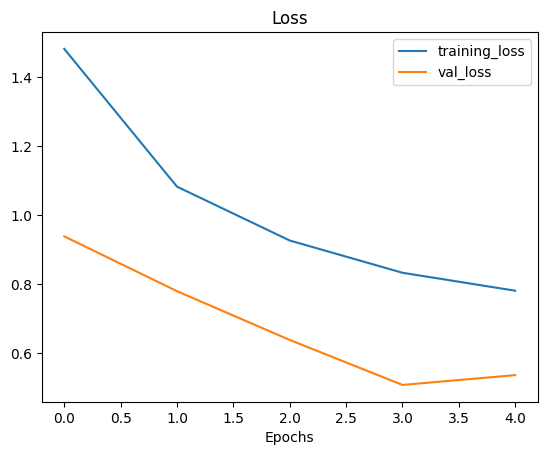

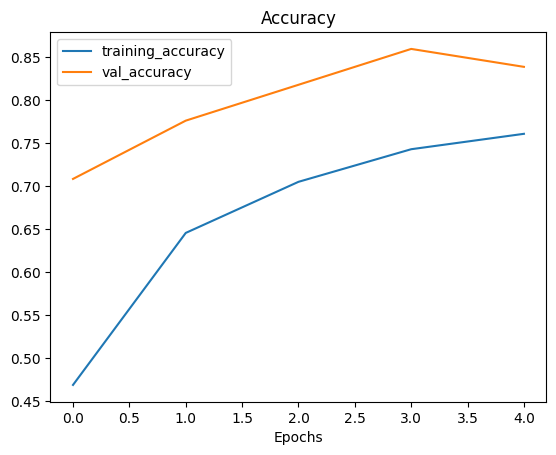

In [ ]:
plot_loss_curves(history)

#fine tuning

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 7,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


In [ ]:
initial_epochs = 5
history_all_percent_data_aug = model_2.fit(train_data_7_classes_full,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231022-154415
Epoch 1/5
105/105 [==============================] - ETA: 0s - loss: 1.5047 - accuracy: 0.4570
Epoch 1: val_loss improved from inf to 1.02306, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
105/105 [==============================] - 62s 393ms/step - loss: 1.5047 - accuracy: 0.4570 - val_loss: 1.0231 - val_accuracy: 0.6719
Epoch 2/5
105/105 [==============================] - ETA: 0s - loss: 1.0890 - accuracy: 0.6453
Epoch 2: val_loss improved from 1.02306 to 0.76432, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
105/105 [==============================] - 31s 288ms/step - loss: 1.0890 - accuracy: 0.6453 - val_loss: 0.7643 - val_accuracy: 0.7865
Epoch 3/5
105/105 [==============================] - ETA: 0s - loss: 0.9394 - accuracy: 0.6993
Epoch 3: val_loss improved from 0.76432 to 0.66879, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckp

In [ ]:
results_2_data_aug = model_2.evaluate(test_data)
results_2_data_aug

26/26 [==============================] - 2s 60ms/step - loss: 0.5341 - accuracy: 0.8487


[0.5340529680252075, 0.8487085103988647]

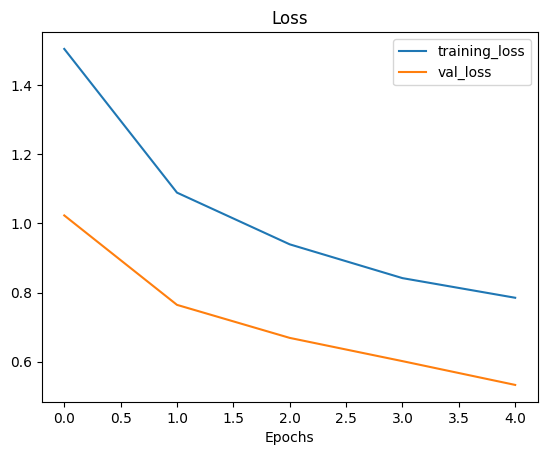

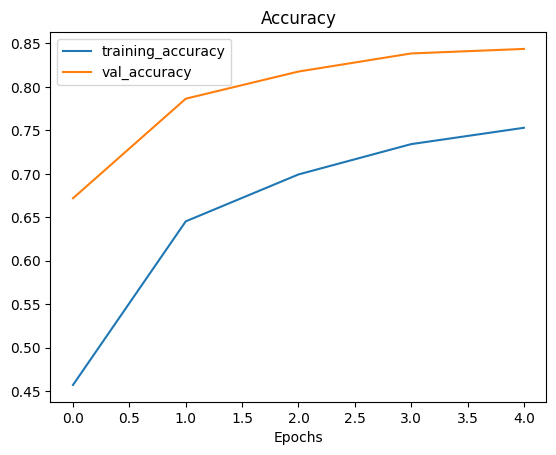

In [ ]:
plot_loss_curves(history_all_percent_data_aug)

#Model 3: Fine Tuning with all Data

In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 7)                 8967

In [ ]:
model_2.layers

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7828e450b4f0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x782986f4b550> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7828e4539870> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7829821c4640> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7828e4625960> | Trainable? True


In [ ]:
model_2 = create_base_model(learning_rate=0.0001)

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

26/26 [==============================] - 6s 80ms/step - loss: 0.5341 - accuracy: 0.8487


[0.534052848815918, 0.8487085103988647]

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_full = model_2.fit(train_data_7_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_all_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231022-155213
Epoch 5/10
105/105 [==============================] - 49s 273ms/step - loss: 0.6713 - accuracy: 0.7742 - val_loss: 0.4407 - val_accuracy: 0.8594
Epoch 6/10
105/105 [==============================] - 24s 229ms/step - loss: 0.5951 - accuracy: 0.7968 - val_loss: 0.2751 - val_accuracy: 0.9062
Epoch 7/10
105/105 [==============================] - 24s 227ms/step - loss: 0.5469 - accuracy: 0.8204 - val_loss: 0.3589 - val_accuracy: 0.8854
Epoch 8/10
105/105 [==============================] - 26s 245ms/step - loss: 0.5322 - accuracy: 0.8192 - val_loss: 0.3383 - val_accuracy: 0.8750
Epoch 9/10
105/105 [==============================] - 23s 217ms/step - loss: 0.4739 - accuracy: 0.8386 - val_loss: 0.2688 - val_accuracy: 0.9062
Epoch 10/10
105/105 [==============================] - 24s 219ms/step - loss: 0.4670 - accuracy: 0.8419 - val_loss: 0.3064 - val_accuracy: 0.9010


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

26/26 [==============================] - 2s 68ms/step - loss: 0.2944 - accuracy: 0.9004


[0.29442980885505676, 0.9003689885139465]

In [ ]:
results_2_data_aug

[0.5340529680252075, 0.8487085103988647]

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.45704057812690735, 0.6452863812446594, 0.699284017086029, 0.7341885566711426, 0.7529832720756531, 0.7741646766662598, 0.7968376874923706, 0.8204057216644287, 0.8192124366760254, 0.8386037945747375, 0.8418854475021362]


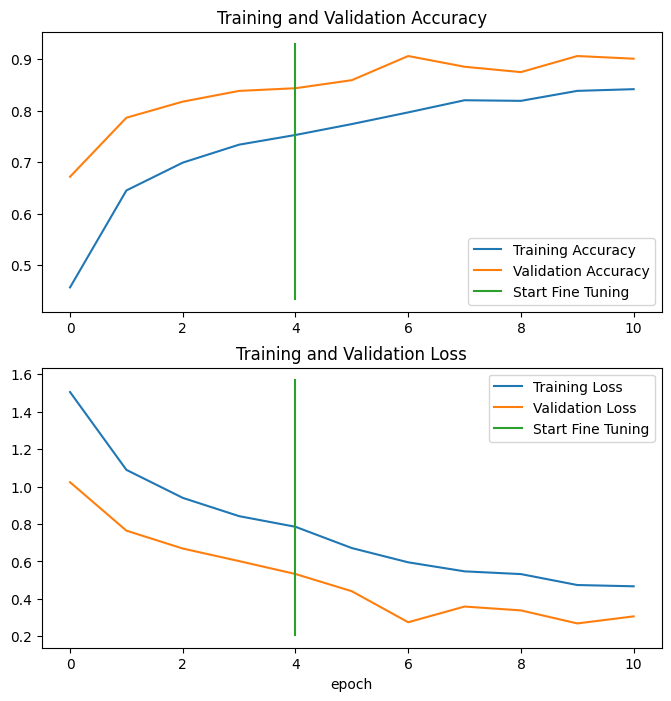

In [ ]:
compare_historys(original_history=history_all_percent_data_aug,
                 new_history=history_fine_full,
                 initial_epochs=5)